#Build ***Neural Network***

In [ ]:
# tricks taken from https://github.com/cpnota/autonomous-learning-library/blob/6d1111afce0d1582de463326f7d078a86e850551/all/presets/atari/models/__init__.py#L16
class Linear0(nn.Linear):
    def reset_parameters(self):
        nn.init.constant_(self.weight, 0.0)
        if self.bias is not None:
            nn.init.constant_(self.bias, 0.0)

class Scale(nn.Module):
    def __init__(self, scale):
        super().__init__()
        self.scale = scale

    def forward(self, x):
        return x * self.scale

class QNetwork(nn.Module):
    def __init__(self, frames=4, n_atoms=51, v_min=-10, v_max=10):
        super(QNetwork, self).__init__()
        self.n_atoms = n_atoms
        self.atoms = torch.linspace(v_min, v_max, steps=n_atoms).to(device)
        self.network = nn.Sequential(
            Scale(1/255),
            nn.Conv2d(frames, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            Linear0(512, env.action_space.n * n_atoms)
        )

    def forward(self, x):
        x = torch.Tensor(x).to(device)
        return self.network(x)

    def get_action(self, x, action=None):
        logits = self.forward(x)
        # probability mass function for each action
        pmfs = torch.softmax(logits.view(len(x), env.action_space.n, self.n_atoms), dim=2)
        q_values = (pmfs*self.atoms).sum(2)
        if action is None:
            action = torch.argmax(q_values, 1)
        return action, pmfs[torch.arange(len(x)), action], q_values, pmfs

#**Let's break down the logic in the NN code:**

This network uses Categorical 51 DQN logic.

**Categorical 51 DQN**, an extension of the Deep Q-Network (DQN), introduces a categorical distribution to represent the Q-function. The key innovation lies in discretizing the action values into a fixed number of atoms, typically 51. The Q-values are modeled as a probability distribution over these discrete atom values. During training, the algorithm adjusts the probabilities assigned to each atom to better approximate the true Q-function. The expected Q-values are computed by summing the products of atom values and their probabilities. This approach enables a more structured representation of uncertainty in Q-value estimation, leading to improved stability and performance in reinforcement learning tasks.

Let's go over the code itself :

**1.Custom Linear Layer (Linear0):**

*   It's a custom linear layer that inherits from nn.Linear.
*   Overrides the reset_parameters method to initialize weights and biases to zero.

**2.Custom Scale Module (Scale):**

*   It's a custom module that inherits from nn.Module.
*   Takes a scale parameter during initialization.
*   Overrides the forward method to scale the input tensor x by the specified scale.

**3.QNetwork Module (QNetwork):**

*   Inherits from nn.Module.
*   Takes parameters like frames (number of frames in the input), n_atoms (number of atoms for the distribution), v_min, and v_max.
*   Initializes a neural network using nn.Sequential with convolutional and linear layers.
*   Applies a scaling layer to normalize input pixel values to the range [0, 1].
Uses convolutional layers to process image input.
*   Applies ReLU activation after each convolutional layer.
*   Flattens the output and applies linear layers with ReLU activation.
*   The final linear layer (Linear0) produces output for each action multiplied by the number of atoms (env.action_space.n * n_atoms).
*   Initializes a set of atoms evenly spaced between v_min and v_max.

**4.Forward Method (forward):**

*   Converts input x to a tensor and sends it to the device.
*   Passes the input through the defined neural network.

**5.get_action Method (get_action):**

*   Takes an input x and an optional action.
*   Calls the forward method to get logits.
*   Applies the *softmax* function along the atom dimension, ***creating a probability mass function (pmfs) for each action***.
Softmax is an activation function that takes a vector of raw scores (logits) and converts them into a probability distribution. In this case, the logits are reshaped to have dimensions (len(x), env.action_space.n, self.n_atoms). The dim=2 argument indicates that ***the softmax is applied along the third dimension (the dimension representing the atoms)***.

*   **Computes the expected Q-values** by multiplying the probabilities by the corresponding atom values and summing along the atom dimension.
The line q_values = (pmfs*self.atoms).sum(2) calculates the expected Q-values using the probability mass functions (pmfs) and the atom values (self.atoms).
Multiplying pmfs by self.atoms performs an element-wise multiplication, where each atom value is multiplied by the corresponding probability in the distribution.
The sum(2) operation sums these products along the third dimension, resulting in the expected Q-values for each action.
*   If an action is provided, it returns the specified action along with its probability mass, Q-values, and the entire probability mass function.

  To recap, the get_action calculate the Q-values for each action in a given state (x). The softmax ensures that the Q-values are represented as a valid probability distribution over the discrete atom values. The expected Q-values are then computed by summing the weighted atom values according to their probabilities. This formulation allows the algorithm to learn and represent the distribution of Q-values for each action.



In summary, the QNetwork is designed for Q-learning with **Categorical 51 DQN**. It uses a neural network to estimate the Q-value distribution for each action and allows for sampling actions based on this distribution. The distribution is represented using a set of discrete atoms. The get_action method facilitates obtaining actions, their probabilities, Q-values, and the entire probability mass function.

# **The Logic Behind Reinforcement Q Learning**
To calculate the loss function we are going to use a copy **Target** NN and **bootstrapping**.
We are going to copy our NN to a *seperate* **Target** NN before each batch. This Target NN will be used to compute the MaxNextQ.

The bootstrapping formula in use is the ***Bellman equation*** :

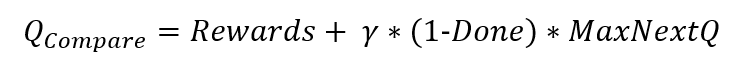

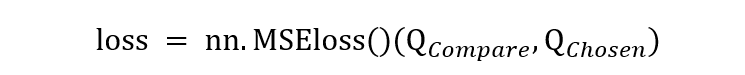

This value of Q Compare will be compared to the value of the "selected Q" by nn.MSEloss(). The "selected Q" is the Q value our NN Agent outputs for the current state and the action that was taken (the action was stored in the replay memory). Of course, our 'Cart' NN outputs 4 possible Q values for the 4 possible actions{0,1,2,3}, but only one action has been taken and stored with an according next state in the memory.

Max NextQ is the max Q value outputted by our Target NN for the next state.

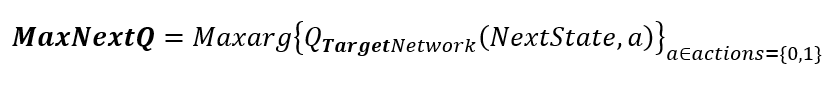